In [135]:
"""
Your job is to tell the retailer if the e-mail campaign was successful.
"""

'\nYour job is to tell the retailer if the e-mail campaign was successful.\n'

### Import Toolbox

In [136]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.sandwich_covariance as sw
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from stargazer.stargazer import Stargazer
from sklearn.preprocessing import StandardScaler

### Import and Clean the Data

In [137]:
df = pd.read_excel("OnlineRetailCampaign-2.xlsx", sheet_name="Data")
df.columns = df.columns.str.lower()
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Rename columns
df.rename(columns={
    'recency': 'last_purchased', 'history': 'past_spending',
    'mens': 'purchased_male', 'womens': 'purchased_female', 'zipcode': 'zipcode_cat',
    'channel': 'purchase_channel', 'campaign': 'email_type', 'visit': 'recent_web_visit',
    'conversion': 'was_converted', 'spend': 'recent_spend'
}, inplace=True)

# Change data types
df = df.astype({
    "last_purchased": int, "past_spending": float, "purchased_male": int, "purchased_female": int,
    "newcustomer": int, "recent_web_visit": int, "was_converted": int, "recent_spend": float
})
df["zipcode_cat"] = df["zipcode_cat"].astype("category")
df["purchase_channel"] = df["purchase_channel"].astype("category")
df["email_type"] = df["email_type"].astype("category")

In [138]:
# Standardize email campaigns
df['email_type'] = df['email_type'].replace(
    {'womens e-mail': 'female', 'mens e-mail': 'male', 'no e-mail': 'none'}
)

# Create spending categories
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1600, 2000, 3000, 4000]
labels = list(range(1, len(bins)))
df['spending_category_yr'] = pd.cut(
    df['past_spending'], bins=bins, labels=labels, right=True, include_lowest=True)
df['spending_category_yr'] = df['spending_category_yr'].astype(int)

# Create a subset of converted customer
df_converted = df[df["was_converted"] == 1].copy() # Filter to conversions only
df_converted.drop(columns=["was_converted"], inplace=True) # Drop the was_converted column
df_converted.to_csv("converted_only.csv", index=False) # Save to csv
df_converted = pd.read_csv("converted_only.csv") # Read the converted csv back in

/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_71014/1263531127.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['email_type'] = df['email_type'].replace(


### Evaluate Skewness of Recent Spending

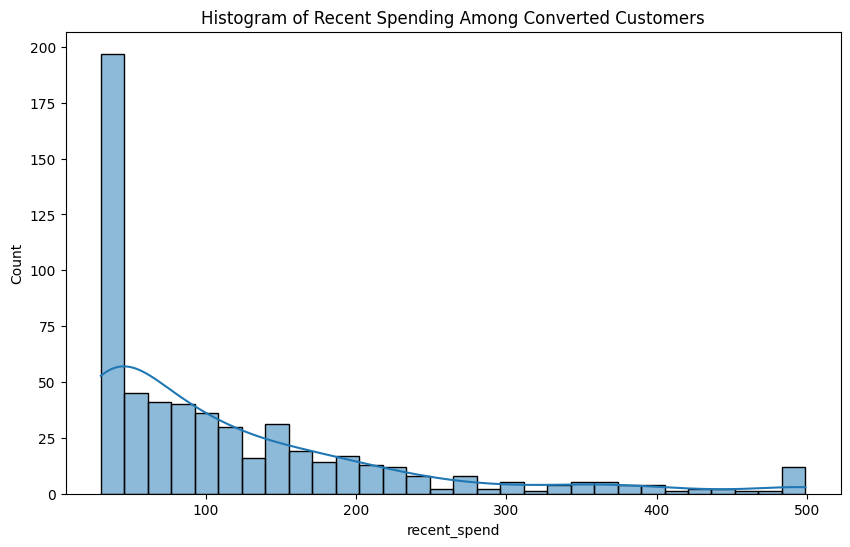

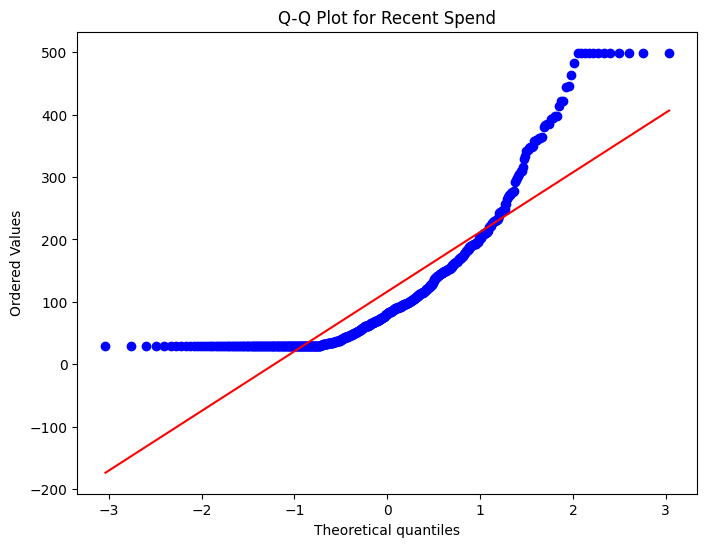

In [139]:
skew_value = df_converted['recent_spend'].skew()
plt.figure(figsize=(10, 6))
sns.histplot(df_converted['recent_spend'], bins=30, kde=True)
plt.title("Histogram of Recent Spending Among Converted Customers")
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_converted['recent_spend'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Recent Spend")
plt.show()

### Apply Log Transformation

In [140]:
df_converted['recent_spend_log'] = np.log1p(df_converted['recent_spend'])

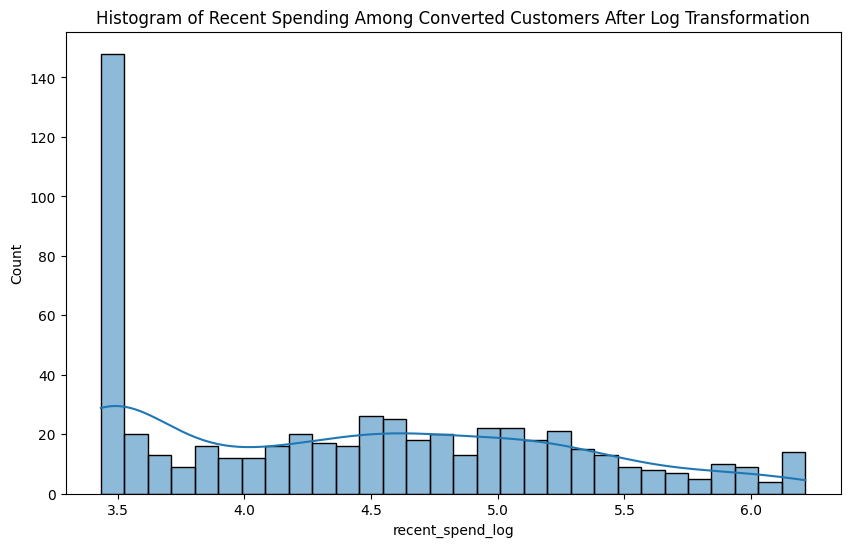

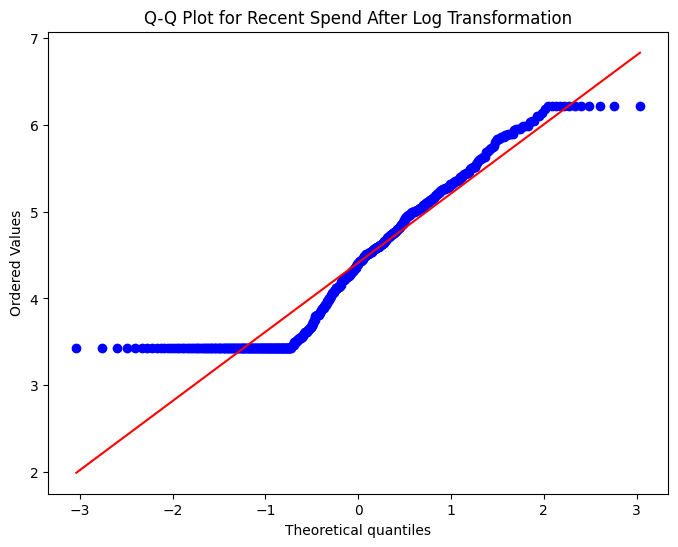

In [141]:
skew_value_log = df_converted['recent_spend'].skew()
plt.figure(figsize=(10, 6))
sns.histplot(df_converted['recent_spend_log'], bins=30, kde=True)
plt.title("Histogram of Recent Spending Among Converted Customers After Log Transformation")
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df_converted['recent_spend_log'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Recent Spend After Log Transformation")
plt.show()

### Create A Hypothesis Table

In [142]:
# Create an updated hypothesis table including the new interaction terms
hypothesis_data = {
    "Predictor": [
        "Last Purchased",
        "Spending Category (Year)",
        "Purchase Channel",
        "Email Type",
        "New Customer",
        "Average Spending",
        "Last Purchased^2",
        "Email * New Customer Interaction",
        "Purchased_Male * Email_Type_Male",
        "Purchased_Female * Email_Type_Female"
    ],
    "Effect (+/-)": [
        "-",     # Higher 'last_purchased' (longer time since purchase) may reduce spending
        "+",     # Higher historical spending is likely to increase future spending
        "?",     # Uncertain effect of phone vs. web channel
        "+",     # Email campaigns are expected to increase spending relative to no email
        "+/-",   # New customers may spend more (enthusiasm) or less (hesitation)
        "+",     # Higher average past spending likely correlates with higher future spending
        "?",     # A squared term captures potential non-linear effects of recency
        "?",     # Interaction between email and new customer status; direction is uncertain
        "+",     # Expected positive effect: Men’s emails work better for customers with a 
                 # history of purchasing men’s products
        "+"      # Expected positive effect: Women’s emails work better for customers with 
                 # a history of purchasing women’s products  
    ],
    "Rationale": [
        "Customers who purchased more recently are more likely to spend, so a larger value may "
        "reduce spending.",
        "Customers with higher historical spending are expected to continue spending more.",
        "The effect of phone versus web may vary depending on user experience and preferences.",
        "Receiving an email campaign (male or female) is hypothesized to boost spending compared "
        "to no email.",
        "New customers might be enthusiastic or cautious, leading to variable spending behavior.",
        "Higher average past spending signals a greater propensity to spend now.",
        "A squared term helps capture non-linear relationships with recency.",
        "The interaction between email and new customer status may modify the effect of "
        "email on spending.",
        "A positive interaction indicates that the effectiveness of a men’s email "
        "campaign is enhanced for customers with prior purchases of men’s merchandise.",
        "A positive interaction suggests that a women’s email campaign is more effective "
        "for customers with a history of purchasing women’s merchandise."
    ]
}

# Convert to DataFrame and export
hypothesis_df = pd.DataFrame(hypothesis_data)
hypothesis_df.to_excel("hypothesis_table_v6.xlsx", index=False)
display(hypothesis_df)

,Predictor,Effect (+/-),Rationale
0,Last Purchased,-,Customers who purchased more recently are more...
1,Spending Category (Year),+,Customers with higher historical spending are ...
2,Purchase Channel,?,The effect of phone versus web may vary depend...
3,Email Type,+,Receiving an email campaign (male or female) i...
4,New Customer,+/-,New customers might be enthusiastic or cautiou...
5,Average Spending,+,Higher average past spending signals a greater...
6,Last Purchased^2,?,A squared term helps capture non-linear relati...
7,Email * New Customer Interaction,?,The interaction between email and new customer...
8,Purchased_Male * Email_Type_Male,+,A positive interaction indicates that the effe...
9,Purchased_Female * Email_Type_Female,+,A positive interaction suggests that a women’s...


### One-Hot Encode Categorical Variables

In [143]:
categorical_columns = ['zipcode_cat', 'purchase_channel', 'email_type']
df_converted_encoded = pd.get_dummies(df_converted, columns=categorical_columns, drop_first=False)

### Feature Engineering

In [144]:
# Create email_newcustomer feature
df_converted_encoded["email_newcustomer"] = df_converted_encoded["email_type_male"] * df_converted_encoded["newcustomer"]
# Create avg_spending
df_converted_encoded["avg_spending"] = df_converted_encoded["past_spending"] / df_converted_encoded["last_purchased"]

### Scale Numerical Features

In [145]:
scaler = StandardScaler()
df_converted_encoded[['last_purchased', 'past_spending']] = scaler.fit_transform(df_converted_encoded[['last_purchased', 'past_spending']])

### Polynomial Terms for Non-Linear Relationships

In [146]:
df_converted_encoded["last_purchased_sq"] = df_converted_encoded["last_purchased"] ** 2

### GLM Models: Gamma Regression with Different Predictor Combinations


In [147]:
# GLM Model 1
glm_model_1 = smf.glm(
    "recent_spend ~ last_purchased + email_type_female + email_type_male + email_type_none + "
    "email_newcustomer + avg_spending",
    data=df_converted_encoded,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

# GLM Model 2
glm_model_2 = smf.glm(
    "recent_spend ~ last_purchased + email_type_female + email_type_male + email_type_none + "
    "purchase_channel_phone + purchase_channel_web + email_newcustomer + avg_spending",
    data=df_converted_encoded,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

# GLM Model 3
glm_model_3 = smf.glm(
    "recent_spend ~ last_purchased + email_type_female + email_type_male + email_type_none + "
    "purchase_channel_phone + purchase_channel_web + newcustomer + spending_category_yr + "
    "email_newcustomer + avg_spending",
    data=df_converted_encoded,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

# GLM Model 4
glm_model_4 = smf.glm(
    formula=(
        "recent_spend ~ last_purchased + email_type_female + email_type_male + email_type_none "
        "+ email_newcustomer + avg_spending "
        "+ purchased_male * email_type_male + purchased_female * email_type_female"
    ),
    data=df_converted_encoded,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias

In [148]:
# Print GLM model summaries
print("==== GLM Model 1 ====")
print(glm_model_1.summary())

print("\n==== GLM Model 2 ====")
print(glm_model_2.summary())

print("\n==== GLM Model 3 ====")
print(glm_model_3.summary())

print("==== GLM Model 4 ====")
print(glm_model_4.summary())

==== GLM Model 1 ====
                 Generalized Linear Model Regression Results                  
Dep. Variable:           recent_spend   No. Observations:                  578
Model:                            GLM   Df Residuals:                      572
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                         0.87183
Method:                          IRLS   Log-Likelihood:                -3311.8
Date:                Mon, 10 Mar 2025   Deviance:                       416.39
Time:                        10:02:21   Pearson chi2:                     499.
No. Iterations:                    14   Pseudo R-squ. (CS):           0.003023
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------


### Heteroskedasticity Corrections

In [149]:
# For each GLM model, we obtain robust covariance estimates.
# Manually compute robust covariance:
robust_cov_1 = sw.cov_white_simple(glm_model_1)
glm_model_1.normalized_cov_params = None
glm_model_1.cov_params_default = robust_cov_1

robust_cov_2 = sw.cov_white_simple(glm_model_2)
glm_model_2.normalized_cov_params = None
glm_model_2.cov_params_default = robust_cov_2

robust_cov_3 = sw.cov_white_simple(glm_model_3)
glm_model_3.normalized_cov_params = None
glm_model_3.cov_params_default = robust_cov_3

robust_cov_4 = sw.cov_white_simple(glm_model_4)
glm_model_4.normalized_cov_params = None
glm_model_4.cov_params_default = robust_cov_4

print("==== GLM Model 1 (Robust SE) ====")
print(glm_model_1.summary())

print("==== GLM Model 2 (Robust SE) ====")
print(glm_model_2.summary())

print("==== GLM Model 3 (Robust SE) ====")
print(glm_model_3.summary())

print("==== GLM Model 4 (Robust SE) ====")
print(glm_model_4.summary())



==== GLM Model 1 (Robust SE) ====
                 Generalized Linear Model Regression Results                  
Dep. Variable:           recent_spend   No. Observations:                  578
Model:                            GLM   Df Residuals:                      572
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                         0.87183
Method:                          IRLS   Log-Likelihood:                -3311.8
Date:                Mon, 10 Mar 2025   Deviance:                       416.39
Time:                        10:02:21   Pearson chi2:                     499.
No. Iterations:                    14   Pseudo R-squ. (CS):           0.003023
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

### Aggregate and Evaluate Models Using Stargazer

In [150]:
stargazer_glm = Stargazer([glm_model_1, glm_model_2, glm_model_3, glm_model_4])
with open("glm_model_results.html", "w") as f:
    f.write(stargazer_glm.render_html())
stargazer_glm

### ||------------------------------- End of Assignment -------------------------------||